# 0.0 Introduction

### A. Errata/Learning Points - previous (submitted) implementation
- I passed in ordinal features `Qualifications` and `Membership` as numeric features instead of categorical. The mapping to numerics should have been with with `OrdinalEncoder` in the pipeline, rather than during clean steps. Some models had a score difference of 0.5%.
- `roc_auc_score` wrongly calculated using y_pred instead of y_pred_proba values. Surprisingly, errors weren't too bad, in the order of 0-2%.
- Evaluation: Should have used `.cv_results_` scores rather than rescoring using entire train/val data. Thus, previous train metrics are incorrect and misleading.
- Wrongly assumed that pipelines with oversampling step would have also oversampled test set when calling predict. Perhaps imbalanced test data also leads to wider gap in AUC scores vs oversampled train set, leading to misinterpretation that overfitting was occurring?
  

### B. Further implementation below
- Implement `ray.tune.search.hyperopt.HyperOptSearch` - more efficient and found better models. Reviewing of multiple rounds of trials/hparams also more easily done with Tensorboard.
- If we balance the dataset, does ROC AUC make for a better metric than F-scores? We can manually tune probability thresholds thereafter to get the precision-recall balance we want.
- Applied PCA, t-SNE, feature_importances_ for tree based classifiers, to get further insights on signal-to-noise ratio in data, and review informative features. If current model is not viable, this step informs us what other data we need to get in the future for a better model.

-----------

# 1.0 Further MLP Implementation with Ray Tune

## 1.1 Set up experiment

### **Assumption/Approach**
ROC AUC is a good measure of a model's predictive power, since it is classification-threshold-invariant. However it is not a good measure when classes are imbalanced. Thus we will use oversampling to overcome that. (Here, we will use SMOTENC instead of RandomOverSampler.)

Thereafter, we can then tune precision-recall manually by selecting a desired threshold to achieve certain targetted metrics (e.g. we want a recall of at least 0.80)

On the other hand, when using F2 as a metric, I'm not sure the HPO process necessarily gives us the best model. Thus, the following experiment is to compare results.

We will run 4 sets of trials (200 runs each):
- a) HyperOptSearch - HistGBM - oversampled data - ROC AUC as metric
- b) HyperOptSearch - HistGBM - imbalanced data - ROC AUC as metric
- c) HyperOptSearch - HistGBM - imbalanced data - F2 as metric
- d) HyperOptSearch - HistGBM - oversampled data - F2 as metric

**Hypothesis: Will ROC AUC as metric give better models than F2?**

Based on the above hypothesis, we expect:
- (a) will produce models better than (d)
- (b) is a control for ROC AUC, given imbalanced data, how much poorer will the models fare.
- (c) compared with (a), can F2 still find good models?
- (d) might as well check for any difference using oversampled data.

In [1]:
##### GLOBAL EXPERIMENT PARAMS

TEST_SIZE = 0.2    # define holdout set size
RANDOM_STATE = 0   # random state for train_test_split & indiv models
CV = 5             # gridsearch cv folds
VERBOSE = 0        # verbosity of alerts
N_TRIALS = 200     # number of trials to conduct during search
LOCAL_DIR = "./results/f2_v_auc4"

from dependencies import *

##### INIT RAY
ray.shutdown()
ray.init(num_cpus=20, num_gpus=0, ignore_reinit_error=True)



2022-11-18 08:22:20,804	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.7
Ray version:,2.0.1
Dashboard:,http://127.0.0.1:8265


In [2]:
##### OVERALL RAY TUNE OBJECTIVES AND TRAINABLES


### HistGBM, oversampled dataset, optimize on AUC
hyper_os_auc = HyperOptSearch(
    # space=searchspace, # our defined searchspace is inexhaustive, so pass it into Tuner rather than into search_alg here
    metric="vald_os_auc_mean",
    # metric="val_os_auc_mean",
    mode="max",
    points_to_evaluate=None,
    n_initial_points=20,
    random_state_seed=RANDOM_STATE,
    gamma=0.25,
)
def trainable_histgbm_os_auc(config):
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()

    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    trai_os_auc = []
    vald_os_auc = []
    test_os_auc = []
    test_im_auc = []
    
    for trai_ind, vald_ind in splitter.split(X_train_os,y_train_os):
        
        clf.set_params(**config)
        clf.fit(X_train_os[trai_ind, :], y_train_os[trai_ind])

        #y_train_pred_os = clf.predict(X_train_os[vald_ind, :])
        #y_test_pred_os  = clf.predict(X_test_os)
        #y_test_pred_im = clf.predict(X_test)
        
        trai_os_auc.append(roc_auc_score(y_train_os[trai_ind], y_score=clf.predict_proba(X_train_os[trai_ind, :])[:,1] ))
        vald_os_auc.append(roc_auc_score(y_train_os[vald_ind], y_score=clf.predict_proba(X_train_os[vald_ind, :])[:,1] ))
        test_os_auc.append(roc_auc_score(y_test_os,            y_score=clf.predict_proba(X_test_os)[:,1] ))
        test_im_auc.append(roc_auc_score(y_test,               y_score=clf.predict_proba(X_test)[:,1] ))
    
    ### REPORT SCORES
    session.report({
        'trai_os_auc_mean' : np.array(trai_os_auc).mean(),
        'vald_os_auc_mean' : np.array(vald_os_auc).mean(),
        'vald_os_auc_std'  : np.array(vald_os_auc).std(),
        'test_os_auc_mean' : np.array(test_os_auc).mean(),
        'test_im_auc_mean' : np.array(test_im_auc).mean(),
    })

### HistGBM, imbalanced dataset, optimize on AUC
hyper_im_auc = HyperOptSearch(
    # space=searchspace, # our defined searchspace is inexhaustive, so pass it into Tuner rather than into search_alg here
    metric="vald_im_auc_mean",
    # metric="val_os_auc_mean",
    mode="max",
    points_to_evaluate=None,
    n_initial_points=20,
    random_state_seed=RANDOM_STATE,
    gamma=0.25,
)
def trainable_histgbm_im_auc(config):
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()

    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    trai_im_auc = []
    vald_im_auc = []
    test_im_auc = []

    for trai_ind, vald_ind in splitter.split(X_train,y_train):
        
        clf.set_params(**config)
        clf.fit(X_train[trai_ind, :], y_train[trai_ind])

        #y_train_pred_im = clf.predict(X_train[vald_ind, :])
        #y_test_pred_im = clf.predict(X_test)
        
        trai_im_auc.append(roc_auc_score(y_train[trai_ind], y_score=clf.predict_proba(X_train[trai_ind, :])[:,1]))
        vald_im_auc.append(roc_auc_score(y_train[vald_ind], y_score=clf.predict_proba(X_train[vald_ind, :])[:,1]))
        test_im_auc.append(roc_auc_score(y_test,            y_score=clf.predict_proba(X_test)[:,1]))
    
    ### REPORT SCORES
    session.report({
        'trai_im_auc_mean' : np.array(trai_im_auc).mean(),
        'vald_im_auc_mean' : np.array(vald_im_auc).mean(),
        'vald_im_auc_std'  : np.array(vald_im_auc).std(),
        'test_im_auc_mean' : np.array(test_im_auc).mean(),
    })

### HistGBM, oversampled dataset, optimize on F2
hyper_os_f2 = HyperOptSearch(
    # space=searchspace, # our defined searchspace is inexhaustive, so pass it into Tuner rather than into search_alg here
    metric="vald_os_f2_mean",
    # metric="val_os_auc_mean",
    mode="max",
    points_to_evaluate=None,
    n_initial_points=20,
    random_state_seed=RANDOM_STATE,
    gamma=0.25,
)
def trainable_histgbm_os_f2(config):
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()

    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    trai_os_f2 = []
    vald_os_f2 = []
    test_os_f2 = []
    test_im_f2 = []
    
    for trai_ind, vald_ind in splitter.split(X_train_os,y_train_os):
        
        clf.set_params(**config)
        clf.fit(X_train_os[trai_ind, :], y_train_os[trai_ind])

        y_trai_pred_os  = clf.predict(X_train_os[trai_ind, :])
        y_vald_pred_os  = clf.predict(X_train_os[vald_ind, :])
        y_test_pred_os  = clf.predict(X_test_os)
        y_test_pred_im  = clf.predict(X_test)

        trai_os_f2.append(fbeta_score(y_train_os[trai_ind], y_pred=y_trai_pred_os, beta=2))        
        vald_os_f2.append(fbeta_score(y_train_os[vald_ind], y_pred=y_vald_pred_os, beta=2))
        test_os_f2.append(fbeta_score(y_test_os,            y_pred=y_test_pred_os, beta=2))
        test_im_f2.append(fbeta_score(y_test,               y_pred=y_test_pred_im, beta=2))
    
    ### REPORT SCORES
    session.report({
        'trai_os_f2_mean' : np.array(trai_os_f2).mean(),
        'vald_os_f2_mean' : np.array(vald_os_f2).mean(),
        'vald_os_f2_std'  : np.array(vald_os_f2).std(),
        'test_os_f2_mean' : np.array(test_os_f2).mean(),
        'test_im_f2_mean' : np.array(test_im_f2).mean(),
    })

### HistGBM, imbalanced dataset, optimize on F2
hyper_im_f2 = HyperOptSearch(
    # space=searchspace, # our defined searchspace is inexhaustive, so pass it into Tuner rather than into search_alg here
    metric="vald_im_f2_mean",
    # metric="val_os_auc_mean",
    mode="max",
    points_to_evaluate=None,
    n_initial_points=20,
    random_state_seed=RANDOM_STATE,
    gamma=0.25,
)
def trainable_histgbm_im_f2(config):
    dataset = Dataset(TEST_SIZE, RANDOM_STATE)
    X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()

    ### CHOOSE CV STRATEGY
    splitter = StratifiedKFold(CV, random_state=RANDOM_STATE, shuffle=True)

    ### CROSS VAL TRAIN LOOP. REPORT VAL SCORES AND TEST SCORES
    trai_im_f2 = []
    vald_im_f2 = []
    test_im_f2 = []

    for trai_ind, vald_ind in splitter.split(X_train,y_train):
        
        clf.set_params(**config)
        clf.fit(X_train[trai_ind, :], y_train[trai_ind])

        y_trai_pred_im = clf.predict(X_train[trai_ind, :])
        y_vald_pred_im = clf.predict(X_train[vald_ind, :])
        y_test_pred_im = clf.predict(X_test)
        
        trai_im_f2.append(fbeta_score(y_train[trai_ind], y_pred=y_trai_pred_im, beta=2))
        vald_im_f2.append(fbeta_score(y_train[vald_ind], y_pred=y_vald_pred_im, beta=2))
        test_im_f2.append(fbeta_score(y_test,            y_pred=y_test_pred_im, beta=2))
    
    ### REPORT SCORES
    session.report({
        'trai_im_f2_mean' : np.array(trai_im_f2).mean(),
        'vald_im_f2_mean' : np.array(vald_im_f2).mean(),
        'vald_im_f2_std'  : np.array(vald_im_f2).std(),
        'test_im_f2_mean' : np.array(test_im_f2).mean(),
    })



In [3]:
### DEF SEARCH SPACE

searchspace_histgbm = {        # RUN 2                       
    'clf__learning_rate'     : tune.loguniform(0.08, 0.3),   
    'clf__max_leaf_nodes'    : tune.randint(4,8),            
    'clf__min_samples_leaf'  : tune.randint(50,150),         
    'clf__max_depth'         : tune.randint(2,6),            
    'clf__l2_regularization' : tune.loguniform(20, 60),      
    'clf__max_iter'          : tune.choice([120]),           
}

# only needed to init for HistGBM to inform model of which are the cat columns
dataset = Dataset(TEST_SIZE, RANDOM_STATE)

### DEF MODEL
clf = Pipeline(steps=[
            ('clf', HistGradientBoostingClassifier(
                        categorical_features=dataset.tfm.cat_feature_mask, 
                        random_state=RANDOM_STATE))])

## 1.2 Trial Runs
Start HyperOptSearch trials (n=200) for each set, and display top 10 models and their metrics.

This section has been iterated over several times, with tweaks to the param space. Refer to table below, describing the param space given for each batch run of 200 trials, and the resulting metrics for each set.

Further detailed notes after the table, on analyses and resulting param space tweaks taken for next subsequent runs. (mainly reducing variance)

<img src='trialrunresults.png'>


#### **1.2.1 Notes after Run #1**
**Trial Set (a) Oversampled, ROC_AUC**
- With the search objective optimizing on `vald_os_auc_mean`, on run #1, we can see the model overfitting train/val, but `test_os_auc_mean` is not too far behind at 0.8760.
- There is a more significant difference of course with `test_im_auc_mean` being original imbalanced data.
- During the model rebuild below, we could try some regularization to see if test scores can be increased.
- Also noted that HistGBM (based on LightGBM) in particular also has tendency to overfit.
<img src='trialset_a.png'>

**Trial Set (b) Imbalanced, ROC_AUC**
- Noting that AUC scores are not a good measure with imbalanced classes, below numbers may not mean as much. (We can still rebuild a model from best params here and check other metrics later.) Nevertheless, from a glance:
- Val scores more in line with test scores. Test scores also somewhat similar to trial set (a).
- However there is quite some variance in the CV folds. Noisy data?
- Train scores still much higher, so some room for regularizing.
<img src='trialset_b.png'>

**Trial Set (d) Oversampled, F2**
- Not as sure if interpretation of F-scores between train/val/test is similar to ROC AUC. (Fom my understanding, F-score is more critical/demanding, therefore the variance would be wider between train/test F-scores than with ROC AUC.) If so:
- Yes, overfitting occurring. Also large difference between F2 scores on oversampled test set and imbalanced test set.
- Further trials needed.
<img src='trialset_c.png'>

**Trial Set (c) Imbalanced, F2**
- Concurs with thoughts on (d), it is very much overfitting. More trials needed with more pruned param space.
<img src='trialset_d.png'>


#### **Trial Set (a) Oversampled, ROC_AUC** (below metrics based on run #4 param space)

In [4]:
tuner_os_auc = tune.Tuner(
    trainable=trainable_histgbm_os_auc,
    param_space=searchspace_histgbm,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyper_os_auc,
    ),
    run_config=RunConfig(
        name="hgb_os_auc",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
    ),
)

results_os_auc = tuner_os_auc.fit()
cfg_hgb_os_auc = trial_res(results_os_auc, 'vald_os_auc_mean')

,trai_os_auc_mean,vald_os_auc_mean,vald_os_auc_std,test_os_auc_mean,test_im_auc_mean
168,0.9736,0.9337,0.0103,0.9108,0.6795
182,0.9729,0.9333,0.0109,0.9101,0.6808
185,0.9737,0.9329,0.0089,0.9062,0.6705
179,0.9741,0.9321,0.0109,0.9103,0.6813
194,0.9720,0.9317,0.0091,0.9063,0.6714
196,0.9732,0.9316,0.0096,0.9103,0.6783
155,0.9735,0.9316,0.0087,0.9065,0.6732
170,0.9730,0.9313,0.0107,0.9052,0.6695
148,0.9735,0.9313,0.0082,0.9067,0.6689
199,0.9728,0.9307,0.0092,0.9058,0.6675


#### **Trial Set (b) Imbalanced, ROC_AUC** (below metrics based on run #4 param space)


In [5]:
tuner_im_auc = tune.Tuner(
    trainable=trainable_histgbm_im_auc,
    param_space=searchspace_histgbm,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyper_im_auc,
    ),
    run_config=RunConfig(
        name="hgb_im_auc",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
    ),
)

results_im_auc = tuner_im_auc.fit()
cfg_hgb_im_auc = trial_res(results_im_auc, 'vald_im_auc_mean')

,trai_im_auc_mean,vald_im_auc_mean,vald_im_auc_std,test_im_auc_mean
113,0.8268,0.6624,0.0345,0.7090
167,0.8129,0.6615,0.0366,0.7057
189,0.8227,0.6607,0.0339,0.7077
152,0.8299,0.6601,0.0348,0.7088
63,0.8247,0.6600,0.0331,0.7064
146,0.8244,0.6599,0.0362,0.7077
162,0.8539,0.6596,0.0314,0.7043
59,0.8430,0.6591,0.0321,0.7081
149,0.8350,0.6590,0.0341,0.7083
85,0.8574,0.6576,0.0309,0.7062


#### **Trial Set (d) Oversampled, F2** (below metrics based on run #4 param space)

In [6]:
tuner_os_f2 = tune.Tuner(
    trainable=trainable_histgbm_os_f2,
    param_space=searchspace_histgbm,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyper_os_f2,
    ),
    run_config=RunConfig(
        name="hgb_os_f2",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
    ),
)

results_os_f2 = tuner_os_f2.fit()
cfg_hgb_os_f2 = trial_res(results_os_f2, 'vald_os_f2_mean')

2022-11-17 11:32:39,438	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.599 s, which may be a performance bottleneck.
2022-11-17 11:32:39,438	WARNING util.py:244 -- The `process_trial_result` operation took 0.601 s, which may be a performance bottleneck.
2022-11-17 11:32:39,439	WARNING util.py:244 -- Processing trial results took 0.602 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2022-11-17 11:32:39,441	WARNING util.py:244 -- The `process_trial_result` operation took 0.603 s, which may be a performance bottleneck.
2022-11-17 11:32:40,530	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 1.086 s, which may be a performance bottleneck.
2022-11-17 11:32:40,530	WARNING util.py:244 -- The `process_trial_result` operation took 1.087 s, which may be a performance bottleneck.
2022-11-17 11:32:40,531	WARNING util.py:244 -- Processing trial results took 1.088 s, which may be a performance bott

,trai_os_f2_mean,vald_os_f2_mean,vald_os_f2_std,test_os_f2_mean,test_im_f2_mean
190,0.8963,0.8452,0.0141,0.7974,0.3018
79,0.8867,0.8443,0.0181,0.8003,0.3162
65,0.8904,0.8411,0.0138,0.7970,0.2940
146,0.8856,0.8407,0.0157,0.8000,0.2906
66,0.8914,0.8405,0.0181,0.8006,0.3006
153,0.8897,0.8392,0.0205,0.7964,0.3044
177,0.8918,0.8391,0.0152,0.7922,0.3123
152,0.8859,0.8390,0.0198,0.7967,0.3094
166,0.8890,0.8386,0.0152,0.7960,0.2887
105,0.8901,0.8382,0.0180,0.7960,0.3098


#### **Trial Set (c) Imbalanced, F2** (below metrics based on run #3 param space)

In [4]:
searchspace_histgbm = {        # RUN 2                       
    'clf__learning_rate'     : tune.loguniform(0.08, 0.4),   
    'clf__max_leaf_nodes'    : tune.randint(4,8),            
    'clf__min_samples_leaf'  : tune.randint(50,150),         
    'clf__max_depth'         : tune.randint(2,6),            
    'clf__l2_regularization' : tune.loguniform(20, 60),      
    'clf__max_iter'          : tune.choice([200]),           
}

tuner_im_f2 = tune.Tuner(
    trainable=trainable_histgbm_im_f2,
    param_space=searchspace_histgbm,
    tune_config=tune.TuneConfig(
        num_samples=N_TRIALS,
        search_alg=hyper_im_f2,
    ),
    run_config=RunConfig(
        name="hgb_im_f2",
        local_dir=LOCAL_DIR,
        verbose=VERBOSE,
    ),
)

results_im_f2 = tuner_im_f2.fit()
cfg_hgb_im_f2 = trial_res(results_im_f2, 'vald_im_f2_mean')

,trai_im_f2_mean,vald_im_f2_mean,vald_im_f2_std,test_im_f2_mean
119,0.5199,0.1662,0.0594,0.2270
148,0.4674,0.1630,0.0478,0.2116
156,0.5529,0.1619,0.0526,0.2245
123,0.5045,0.1615,0.0539,0.2210
30,0.5087,0.1579,0.0336,0.2243
194,0.5296,0.1546,0.0567,0.2143
142,0.4922,0.1544,0.0400,0.2047
84,0.5484,0.1539,0.0560,0.2170
65,0.5563,0.1538,0.0543,0.2121
73,0.3877,0.1526,0.0516,0.2140


## 1.3 Overall impressions on trial results:
- Between run #1 and run #4, 
  - OS AUC, IM AUC scores improved.
  - OS F2 scores improved
  - IM F2 scores improved after 3 runs, dropped at run #4, suggesting it probably needs different param limits.
- However, AUC metrics are easier to check overfit than F2 metrics, and possible stopping point for tuning. e.g. train 97% val 93% test 90%, not much headroom left. Whereas F2 metrics we may not get such close figures, so they may be less indicative of reaching a stopping point for tuning.
- **Rebuild models using run #4 best configs for the first 3, and run #3 config for IM F2.**

## 1.4 Train and score models using best configs of each trial set
- *Unproven Assumption: Although using previous best configs, rebuilt models might still overfit slightly, since it is now seeing a larger subset of data. Thus there's a possibility we need to regularize slightly.*
- Since the main point of comparison is whether using AUC is more optimal than F2, we will use configs from the best runs for each set. i.e Trials OS AUC, IM AUC, OS F2 get run 4 configs, IM F2 gets run 3 best config.

In [4]:
### BEST CONFIGS AT RUN 4

cfg_hgb_os_auc = { 
    'clf__learning_rate': 0.2672682267218073,
    'clf__max_depth': 5,
    'clf__max_iter': 120,
    'clf__max_leaf_nodes': 7,
    'clf__min_samples_leaf': 54}
cfg_hgb_im_auc = {
    'clf__l2_regularization': 25.598462328296065,
    'clf__learning_rate': 0.11395030074020093,
    'clf__max_depth': 5,
    'clf__max_iter': 120,
    'clf__max_leaf_nodes': 5,
    'clf__min_samples_leaf': 50}
cfg_hgb_os_f2 = {
    'clf__l2_regularization': 20.528552683476025,
    'clf__learning_rate': 0.29962462823174435,
    'clf__max_depth': 5,
    'clf__max_iter': 120,
    'clf__max_leaf_nodes': 7,
    'clf__min_samples_leaf': 72}
# cfg_hgb_im_f2 = {
#     'clf__l2_regularization': 23.59723002196631,
#     'clf__learning_rate': 0.29035919905130614,
#     'clf__max_depth': 4,
#     'clf__max_iter': 120,
#     'clf__max_leaf_nodes': 7,
#     'clf__min_samples_leaf': 94}



### BEST CONFIGS AT RUN 3

cfg_hgb_im_f2 = {
    'clf__l2_regularization': 23.342181235838876,
    'clf__learning_rate': 0.364634462597879,
    'clf__max_depth': 4,
    'clf__max_iter': 200,
    'clf__max_leaf_nodes': 7,
    'clf__min_samples_leaf': 96}

In [5]:
from pprint import pprint
# pprint(cfg_hgb_os_auc)
# pprint(cfg_hgb_im_auc)
# pprint(cfg_hgb_os_f2)
# pprint(cfg_hgb_im_f2)

In [6]:
##### REBUILD MODEL FROM BEST CONFIG
dataset = Dataset(TEST_SIZE, RANDOM_STATE)
X_train, X_test, y_train, y_test, X_train_os, X_test_os, y_train_os, y_test_os = dataset.get_transformed_ordinal_oversample()

hgb_os_auc = Pipeline(steps=[('clf', HistGradientBoostingClassifier(categorical_features=dataset.tfm.cat_feature_mask, random_state=RANDOM_STATE))])
hgb_im_auc = Pipeline(steps=[('clf', HistGradientBoostingClassifier(categorical_features=dataset.tfm.cat_feature_mask, random_state=RANDOM_STATE))])
hgb_os_f2 = Pipeline(steps=[('clf', HistGradientBoostingClassifier(categorical_features=dataset.tfm.cat_feature_mask, random_state=RANDOM_STATE))])
hgb_im_f2 = Pipeline(steps=[('clf', HistGradientBoostingClassifier(categorical_features=dataset.tfm.cat_feature_mask, random_state=RANDOM_STATE))])

hgb_os_auc.set_params(**cfg_hgb_os_auc)
hgb_im_auc.set_params(**cfg_hgb_im_auc)
hgb_os_f2.set_params(**cfg_hgb_os_f2)
hgb_im_f2.set_params(**cfg_hgb_im_f2)

hgb_os_auc.fit(X_train_os, y_train_os)
hgb_im_auc.fit(X_train, y_train)
hgb_os_f2.fit(X_train_os, y_train_os)
hgb_im_f2.fit(X_train, y_train)


### AUC METRICS ON RETRAINED
train_auc_hgb_os_auc = roc_auc_score(y_true=y_train, y_score=hgb_os_auc.predict_proba(X_train)[:,1])
train_auc_hgb_im_auc = roc_auc_score(y_true=y_train, y_score=hgb_im_auc.predict_proba(X_train)[:,1])
train_auc_hgb_os_f2  = roc_auc_score(y_true=y_train, y_score=hgb_os_f2.predict_proba(X_train)[:,1])
train_auc_hgb_im_f2  = roc_auc_score(y_true=y_train, y_score=hgb_im_f2.predict_proba(X_train)[:,1])

test_auc_hgb_os_auc = roc_auc_score(y_true=y_test, y_score=hgb_os_auc.predict_proba(X_test)[:,1])
test_auc_hgb_im_auc = roc_auc_score(y_true=y_test, y_score=hgb_im_auc.predict_proba(X_test)[:,1])
test_auc_hgb_os_f2  = roc_auc_score(y_true=y_test, y_score=hgb_os_f2.predict_proba(X_test)[:,1])
test_auc_hgb_im_f2  = roc_auc_score(y_true=y_test, y_score=hgb_im_f2.predict_proba(X_test)[:,1])

print("train_auc_hgb_os_auc : ", round(train_auc_hgb_os_auc, 4))
print("train_auc_hgb_im_auc : ", round(train_auc_hgb_im_auc, 4))
print("train_auc_hgb_os_f2  : ", round(train_auc_hgb_os_f2 , 4))
print("train_auc_hgb_im_f2  : ", round(train_auc_hgb_im_f2 , 4))

print("test_auc_hgb_os_auc : ", round(test_auc_hgb_os_auc, 4))
print("test_auc_hgb_im_auc : ", round(test_auc_hgb_im_auc, 4))
print("test_auc_hgb_os_f2  : ", round(test_auc_hgb_os_f2 , 4))
print("test_auc_hgb_im_f2  : ", round(test_auc_hgb_im_f2 , 4))


train_auc_hgb_os_auc :  0.9442
train_auc_hgb_im_auc :  0.8178
train_auc_hgb_os_f2  :  0.8835
train_auc_hgb_im_f2  :  0.9509
test_auc_hgb_os_auc :  0.7044
test_auc_hgb_im_auc :  0.7198
test_auc_hgb_os_f2  :  0.6759
test_auc_hgb_im_f2  :  0.6619


## 1.5 Tuning Precision-Recall using Probability Thresholds - Train Data
- In our case, we simply tune for max F2, to compare results between the AUC-optimized and F2-optimized models.


"The threshold in scikit learn is 0.5 for binary classification and whichever class has the greatest probability for multiclass classification. In many problems a much better result may be obtained by adjusting the threshold. However, this must be done with care and NOT on the holdout test data but by cross validation on the training data. If you do any adjustment of the threshold on your test data you are just overfitting the test data." -- https://stackoverflow.com/questions/19984957/scikit-learn-predict-default-threshold


- `(clf.predict_proba(X_test)[:,1] >= 0.26).astype(bool)` this can be used in place of `.predict` for inference.

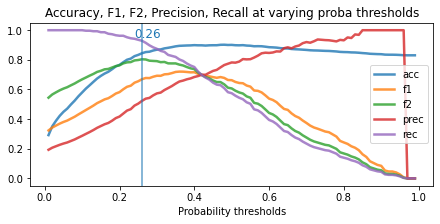

,threshold,accuracy,f1,f2,precision,recall
25,0.2600,0.8445,0.6691,0.8039,0.5230,0.9286


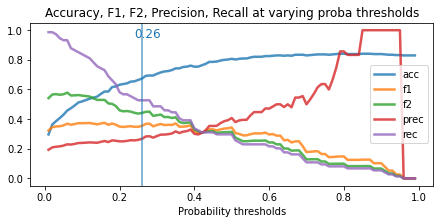

,threshold,accuracy,f1,f2,precision,recall
25,0.2600,0.6736,0.3545,0.4412,0.2671,0.5270


In [12]:
# TRAIN
proba_table = tune_for_recall(hgb_os_auc, X_train, y_train, .26)
display(proba_table[(proba_table['threshold']>0.25)&(proba_table['threshold']<0.27)])

# TEST
proba_table = tune_for_recall(hgb_os_auc, X_test, y_test, .26)
display(proba_table[(proba_table['threshold']>0.25)&(proba_table['threshold']<0.27)])

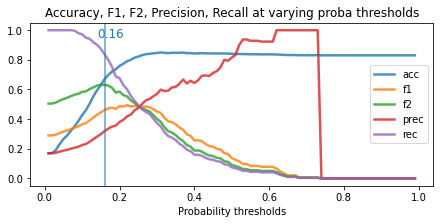

,threshold,accuracy,f1,f2,precision,recall
15,0.1600,0.6699,0.4620,0.6317,0.3191,0.8367


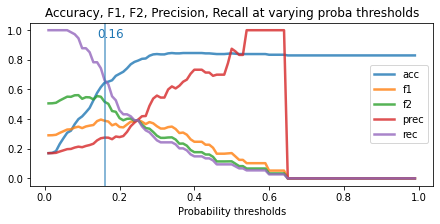

,threshold,accuracy,f1,f2,precision,recall
15,0.1600,0.6460,0.3889,0.5169,0.2753,0.6622


In [16]:
# TRAIN
proba_table = tune_for_recall(hgb_im_auc, X_train, y_train, 0.16)
display(proba_table[(proba_table['threshold']>0.151)&(proba_table['threshold']<0.17)])

# TEST
proba_table = tune_for_recall(hgb_im_auc, X_test, y_test, 0.16)
display(proba_table[(proba_table['threshold']>0.151)&(proba_table['threshold']<0.17)])

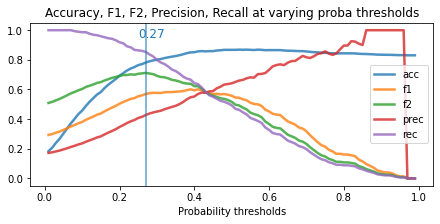

,threshold,accuracy,f1,f2,precision,recall
26,0.2700,0.7817,0.5698,0.7119,0.4276,0.8537


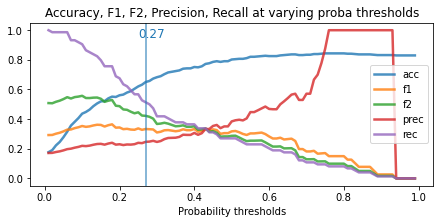

,threshold,accuracy,f1,f2,precision,recall
26,0.2700,0.6506,0.3333,0.4222,0.2468,0.5135


In [17]:
# TRAIN
proba_table = tune_for_recall(hgb_os_f2, X_train, y_train, 0.27)
display(proba_table[(proba_table['threshold']>0.26)&(proba_table['threshold']<0.28)])

# TEST
proba_table = tune_for_recall(hgb_os_f2, X_test, y_test, 0.27)
display(proba_table[(proba_table['threshold']>0.26)&(proba_table['threshold']<0.28)])

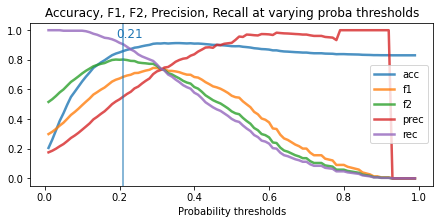

,threshold,accuracy,f1,f2,precision,recall
20,0.2100,0.8594,0.6856,0.8022,0.5519,0.9048


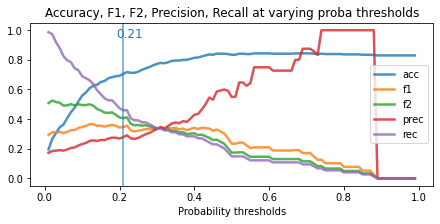

,threshold,accuracy,f1,f2,precision,recall
20,0.2100,0.7057,0.3469,0.4067,0.2787,0.4595


In [18]:
# TRAIN
proba_table = tune_for_recall(hgb_im_f2, X_train, y_train, 0.21)
display(proba_table[(proba_table['threshold']>0.2)&(proba_table['threshold']<0.22)])

# TEST
proba_table = tune_for_recall(hgb_im_f2, X_test, y_test, 0.21)
display(proba_table[(proba_table['threshold']>0.2)&(proba_table['threshold']<0.22)])

## 1.6 Conclusion

From section 1.5 above, tuning thresholds and selecting for max F2, we have:


**TRAIN METRICS**
model  | thre | acc    | f1    | f2   | precision | recall | auc
-------|------|--------|--------|--------|--------|--------|-------
OS_AUC | 0.26 | 0.8445 | 0.6691 | 0.8039 | 0.5230 | 0.9286 | 0.9442
IM_AUC | 0.16 | 0.6699 | 0.4620 | 0.6317 | 0.3191 | 0.8367 | 0.8178
OS_F2  | 0.27 | 0.7817 | 0.5698 | 0.7119 | 0.4276 | 0.8537 | 0.8835
IM_F2  | 0.21 | 0.8594 | 0.6856 | 0.8022 | 0.5519 | 0.9048 | 0.9509


**TEST METRICS**
model  | thre | acc    | f1    | f2   | precision | recall | auc
-------|------|--------|--------|--------|--------|--------|-------
OS_AUC | 0.26 | 0.6736 | 0.3545 | 0.4412 | 0.2671 | 0.5270 | 0.7044
IM_AUC | 0.16 | 0.6460 | 0.3889 | 0.5169 | 0.2753 | 0.6622 | 0.7198
OS_F2  | 0.27 | 0.6506 | 0.3333 | 0.4222 | 0.2468 | 0.5135 | 0.6759
IM_F2  | 0.21 | 0.7057 | 0.3469 | 0.4067 | 0.2787 | 0.4595 | 0.6619

--------------

### Conclusion
**Based on the above, it's not conclusive that ROC_AUC will necessarily find a model with better predictive power. The OS_AUC and IM_F2 models have very similar train metrics and the larger difference in test metrics perhaps only suggests more tuning would have been helpful.**

--------------

# 2.0 Misc Feature Analysis, Review Data SNR
- Most of the nominal categorical features have low signal, other than if their Work Domain is IT.
- Data itself is quite noisy, perhaps further user surveys can be conducted to gather more informative fields. The high-signal features here could prompt us specific data of interest to capture. e.g. income, usage time, travel time, and age play a stronger factor. Data that delves further into/relates to these areas could prove to be more informative.
- Maybe not that relevant in the scope of MLP, however in terms of analytics/biz strategy, more data regarding lifestyle/social activity (e.g. why do you come to the country club, what activities/facilities do you use most/how do you rate the country club) etc might prove to be more informative.

## 2.1 PCA - cumulative explained variance

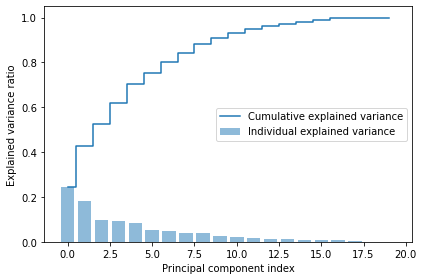

In [41]:
from sklearn.decomposition import PCA

data = Dataset(TEST_SIZE, RANDOM_STATE)
X,y = data.get_onehot_imbalanced()

pca = PCA()
X_pca = pca.fit_transform(X)

import matplotlib.pyplot as plt
# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

- 1st 3 principal components captures about half the explained variance. 
- If dataset was extremely high-dim, this can be applied in the pipeline to speed up training.
- But since data is noisy, we might lose some information and decrease model accuracy slightly.

## 2.2 PCA - magnitude of original features

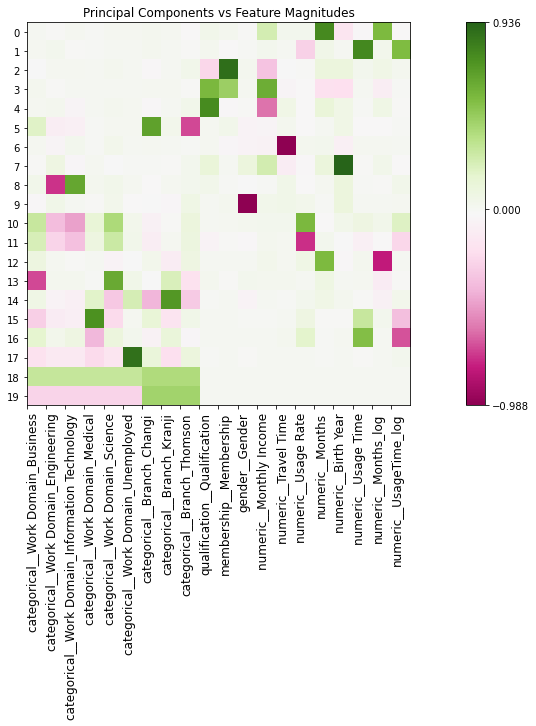

In [42]:
fig = plt.figure(figsize=(10, 14))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'PiYG')

feature_names = list(data.tfm.transformer.get_feature_names_out())

plt.gca().set_xticks(np.arange(-.5, len(feature_names)-0.5));
plt.gca().set_yticks(np.arange(0, 20));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_title('Principal Components vs Feature Magnitudes')
# plt.gca().set_yticklabels(np.arange(0,20,1), va='bottom', fontsize=12);

plt.subplots_adjust(left=None, bottom=0.5)

plt.colorbar(orientation='vertical', ticks=[pca.components_.min(), 0, pca.components_.max()], pad=0.1);
plt.show()

## 2.3 Feature_importances_ for tree based classifiers

In [66]:
rfc = Pipeline(steps=[
    ('clf', RandomForestClassifier(
        max_depth=8, 
        n_estimators=300, 
        min_samples_split=100, 
        min_impurity_decrease=0.001, 
        class_weight='balanced'))
]).fit(X_train, y_train)

print('train_roc_auc :', roc_auc_score(y_train, rfc.predict(X_train)))
print('test_roc_auc :', roc_auc_score(y_test, rfc.predict(X_test)))

train_roc_auc : 0.7391519714681988
test_roc_auc : 0.6528786404132665


In [67]:
def feature_importance(clf):
    try:
        # print(clf.feature_names_in_)

        feature_importances = clf['clf'].feature_importances_

        data = Dataset(TEST_SIZE,RANDOM_STATE)
        data.get_onehot_imbalanced() # needs to be fitted
        feature_name_transformed_list = data.tfm.transformer.get_feature_names_out()

        # feature_name_transformed_list = []
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[0][1]['encoder'].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[1][1].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[2][1].get_feature_names_out() ))
        # feature_name_transformed_list.extend(list( clf['prep'].transformers_[3][1].get_feature_names_out() ))

        return pd.DataFrame(feature_importances, index=feature_name_transformed_list, columns=['importance']).sort_values(['importance'], ascending=False)

    except:       
        return np.nan

feature_importance(rfc)

,importance
numeric__Monthly Income,0.1947
numeric__Usage Time,0.1362
numeric__Birth Year,0.1102
numeric__UsageTime_log,0.1039
numeric__Travel Time,0.0942
numeric__Months,0.0823
numeric__Months_log,0.0805
numeric__Usage Rate,0.0652
qualification__Qualification,0.0254
membership__Membership,0.0201


## 2.4 Visualise actual vs predicted against 2 feature dims or PCA(2)
- In this case, neither very informative. 

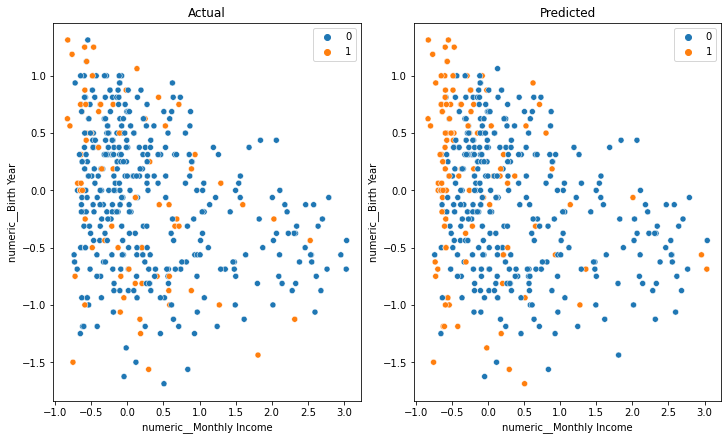

In [68]:
import seaborn as sns
def plot_2dim(clf, X, y, dims):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6), constrained_layout=True)

    y_pred = clf.predict(X)
    sns.scatterplot(x=X[:, dims[0]], y=X[:, dims[1]], hue=y, ax=ax1, )
    sns.scatterplot(x=X[:, dims[0]], y=X[:, dims[1]], hue=y_pred, ax=ax2, )
    ax1.set_title('Actual')
    ax1.set_ylabel(data.tfm.transformer.get_feature_names_out()[dims[1]])
    ax1.set_xlabel(data.tfm.transformer.get_feature_names_out()[dims[0]])
    ax2.set_title('Predicted')
    ax2.set_ylabel(data.tfm.transformer.get_feature_names_out()[dims[1]])
    ax2.set_xlabel(data.tfm.transformer.get_feature_names_out()[dims[0]])
    

data = Dataset(TEST_SIZE, RANDOM_STATE)
X_train, X_test, y_train, y_test = data.get_transformed_onehot()

plot_2dim(rfc, X_test, y_test, (12,16))

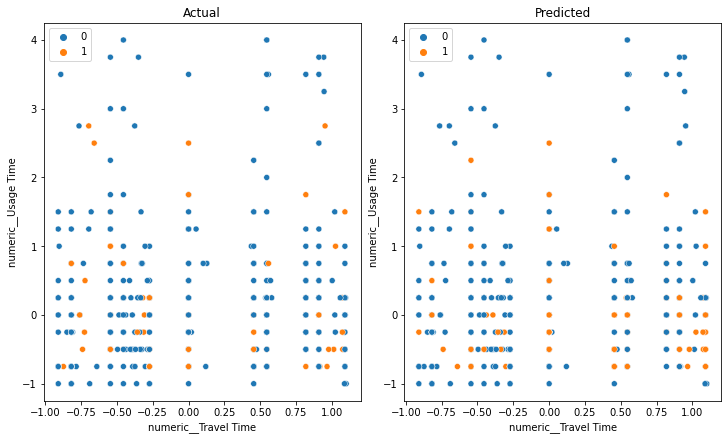

In [69]:
plot_2dim(rfc, X_test, y_test, (13,17))

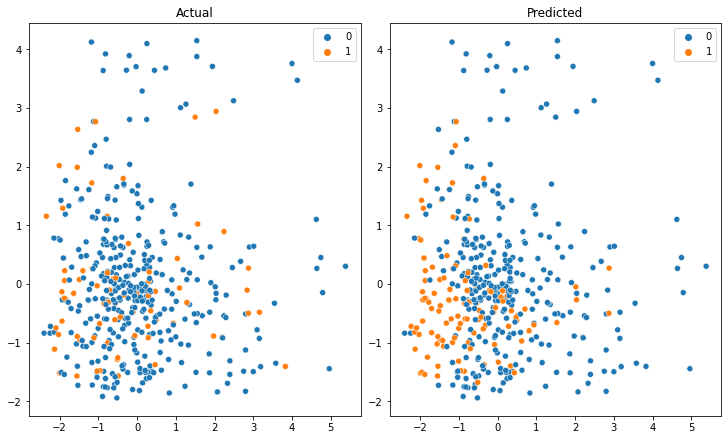

In [70]:
def plot_pcadim(clf,pca, X, y):
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6), constrained_layout=True)

    pca = PCA(2)
    # data = Dataset()
    # X,y = data.get_onehot_imbalanced()
    X_pca = pca.fit_transform(X,y)

    y_pred = clf.predict(X)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, ax=ax1, )
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_pred, ax=ax2, )
    ax1.set_title('Actual')
    ax2.set_title('Predicted')



data = Dataset(TEST_SIZE, RANDOM_STATE)
X_train, X_test, y_train, y_test = data.get_transformed_onehot()

plot_pcadim(rfc, pca, X_test, y_test)

## 2.4 tSNE visualisation
- attempt to see if clusters/boundaries can be found, but there doesn't seem to be distinct separators between pos/neg class.

c:\Anaconda\envs\python\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
c:\Anaconda\envs\python\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


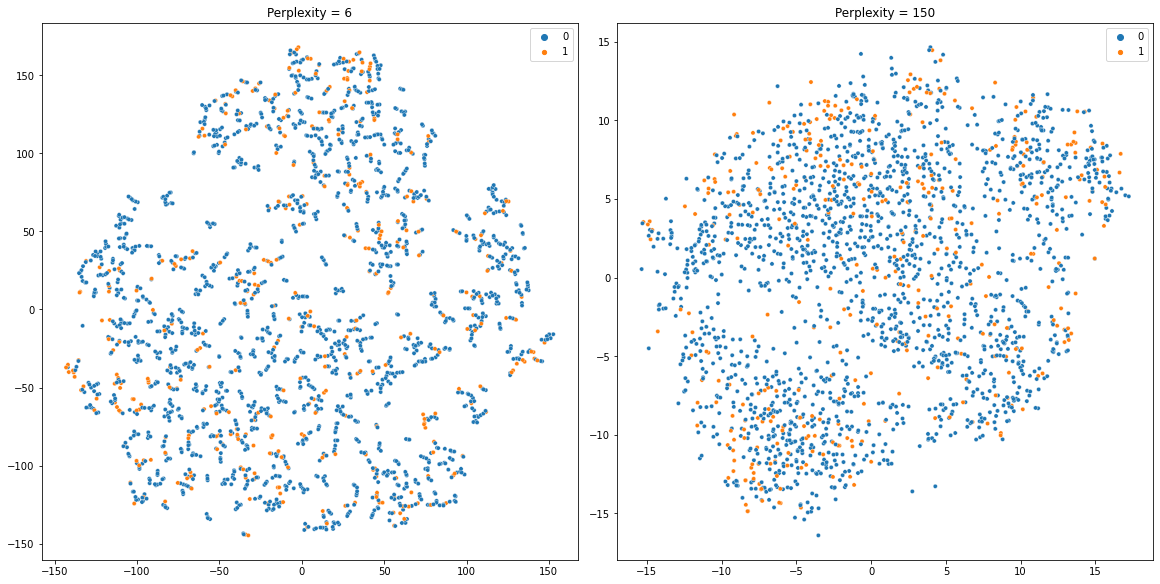

In [47]:
from sklearn.manifold import TSNE
import seaborn as sns

data = Dataset(TEST_SIZE,RANDOM_STATE)
X,y = data.get_ordinal_imbalanced()

perplexities = [6, 150]


fig, axs = plt.subplots(1,2, figsize=(16,8), constrained_layout=True)

for i, ax in zip(perplexities, axs.ravel()):
    tsne = TSNE(2, perplexity=i, n_jobs=-1, init='pca', learning_rate=1000, n_iter=5000)
    X_tsne = tsne.fit_transform(X)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, ax=ax, size=1)
    ax.set_title(f'Perplexity = {i}')




- As expected, quite noisy dataset in general. with no distinct separation of positive and negative classes. Probably won't be able to significantly improve scores by tuning further. 

-----------------

In [19]:
!"C:\Program Files\VideoLAN\VLC\vlc.exe" d:\complete.mp3

[000002c827829ae0] main libvlc: Running vlc with the default interface. Use 'cvlc' to use vlc without interface.
